# Exploring the NHC Advisories and Sea Surface Height during Hurricane Irma


This notebook aims to demonstrate how to create a simple interactive GIS map with the National Hurricane Center predictions [1] and the observed sea surface height from CO-OPS [2].


See https://tidesandcurrents.noaa.gov/quicklook/view.html?name=IRMA for the latest information on Irma.

1. http://www.nhc.noaa.gov/gis/
2. https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/

First we set a date around the 2017-09-07 to search for the observations.

In [1]:
from datetime import datetime, timedelta

event_date = datetime(2017, 9, 7)

start_time = event_date - timedelta(days=3)
end_time = event_date + timedelta(days=4)

Now we need to set all the parameters for the filter: the units for the observations, the bounding box, and the SOS name for the variable of interest. Next, we can use `pyoos` to assemble a collector to download the data into a pandas `DataFrame`.

In [2]:
import cf_units
from ioos_tools.ioos import collector2table
import pandas as pd
from pyoos.collectors.coops.coops_sos import CoopsSos
from retrying import retry


# We need to retry in case of failure b/c the server cannot handle
# the high traffic during events like Irma.
@retry(stop_max_attempt_number=5, wait_fixed=3000)
def get_coops(sos_name='water_surface_height_above_reference_datum',
              units=cf_units.Unit('meters'),
              bbox=[-86, 12.5, -57, 30.5],
              verbose=False):
    collector = CoopsSos()
    collector.set_bbox(bbox)
    collector.end_time = end_time
    collector.start_time = start_time
    collector.variables = [sos_name]
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    config = dict(
        units=units,
        sos_name=sos_name,
    )

    data = collector2table(
        collector=collector,
        config=config,
        col='{} ({})'.format(sos_name, units.format(cf_units.UT_ISO_8859_1))
    )

    # Clean the table.
    table = dict(
        station_name=[s._metadata.get('station_name') for s in data],
        station_code=[s._metadata.get('station_code') for s in data],
        sensor=[s._metadata.get('sensor') for s in data],
        lon=[s._metadata.get('lon') for s in data],
        lat=[s._metadata.get('lat') for s in data],
        depth=[s._metadata.get('depth', 'NA') for s in data],
    )

    table = pd.DataFrame(table).set_index('station_name')
    if verbose:
        print('Collector offerings')
        print('{}: {} offerings'.format(title, len(ofrs)))
    return data, table

In [3]:
bbox = [-86, 12.5, -57, 30.5]

ssh, ssh_table = get_coops(
    sos_name='water_surface_height_above_reference_datum',
    units=cf_units.Unit('meters'),
    bbox=bbox,
)

ssh_table

,depth,lat,lon,sensor,station_code
station_name,,,,,
"Mayport (Bar Pilots Dock), FL",None,30.3982,-81.4279,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720218:A1,8720218
"Dames Point, FL",None,30.3872,-81.5592,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720219:A1,8720219
"Southbank Riverwalk, St Johns River, FL",None,30.3205,-81.6591,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720226:B1,8720226
"Racy Point, St Johns River, FL",None,29.8002,-81.5498,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720625:A1,8720625
"Trident Pier, Port Canaveral, FL",None,28.4158,-80.5931,urn:ioos:sensor:NOAA.NOS.CO-OPS:8721604:A1,8721604
"Lake Worth Pier, Atlantic Ocean, FL",None,26.6128,-80.0342,urn:ioos:sensor:NOAA.NOS.CO-OPS:8722670:N1,8722670
"Virginia Key, Biscayne Bay, FL",None,25.7317,-80.1617,urn:ioos:sensor:NOAA.NOS.CO-OPS:8723214:A1,8723214
"Vaca Key, Florida Bay, FL",None,24.7110,-81.1065,urn:ioos:sensor:NOAA.NOS.CO-OPS:8723970:A1,8723970
"Key West, FL",None,24.5557,-81.8079,urn:ioos:sensor:NOAA.NOS.CO-OPS:8724580:A1,8724580


In [4]:
wind_speed, wind_speed_table = get_coops(
    sos_name='wind_speed',
    units=cf_units.Unit('m/s'),
    bbox=bbox,
)

wind_speed_table

,depth,lat,lon,sensor,station_code
station_name,,,,,
"Navy Fuel Depot, FL",None,30.4000,-81.6267,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720215:C1,8720215
"Mayport (Bar Pilots Dock), FL",None,30.3982,-81.4279,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720218:C1,8720218
"Blount Island Command, FL",None,30.3926,-81.5225,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720233:C1,8720233
"I-295 Bridge, St Johns River, FL",None,30.1917,-81.6917,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720357:C1,8720357
"Trident Pier, Port Canaveral, FL",None,28.4158,-80.5931,urn:ioos:sensor:NOAA.NOS.CO-OPS:8721604:C1,8721604
"Lake Worth Pier, Atlantic Ocean, FL",None,26.6128,-80.0342,urn:ioos:sensor:NOAA.NOS.CO-OPS:8722670:C1,8722670
"Virginia Key, Biscayne Bay, FL",None,25.7314,-80.1618,urn:ioos:sensor:NOAA.NOS.CO-OPS:8723214:C1,8723214
"Vaca Key, Florida Bay, FL",None,24.7110,-81.1065,urn:ioos:sensor:NOAA.NOS.CO-OPS:8723970:C1,8723970
"Key West, FL",None,24.5557,-81.8079,urn:ioos:sensor:NOAA.NOS.CO-OPS:8724580:C1,8724580


In [5]:
common = set(ssh_table['station_code']).intersection(wind_speed_table['station_code'])

In [6]:
ssh_obs, win_obs = [], []
for station in common:
    ssh_obs.extend([obs for obs in ssh if obs._metadata['station_code'] == station])
    win_obs.extend([obs for obs in wind_speed if obs._metadata['station_code'] == station])

In [7]:
index = pd.date_range(start=start_time.replace(tzinfo=None),
                      end=end_time.replace(tzinfo=None),
                      freq='15min')

# Re-index and rename series.
ssh_observations = []
for series in ssh_obs:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    obs.name = _metadata['station_name']
    ssh_observations.append(obs)

winds_observations = []
for series in win_obs:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    obs.name = _metadata['station_name']
    winds_observations.append(obs)

Let's take a look at some stations to see if the data is OK. Below we have a station in Naples, FL along the Gulf of Mexico.

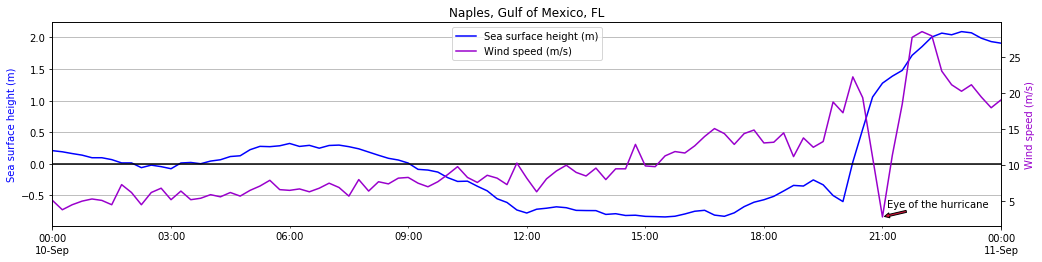

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

w = [obs for obs in winds_observations if obs._metadata['station_code'] == '8725110'][0]
s = [obs for obs in ssh_observations if obs._metadata['station_code'] == '8725110'][0]

fig, ax = plt.subplots(figsize=(17, 3.75))
s['2017-9-10':].plot(ax=ax, label='Sea surface height (m)', color='#0000ff')
ax1 = w['2017-9-10':].plot(ax=ax, label='Wind speed (m/s)', color='#9900cc', secondary_y=True)
ax.set_title(w._metadata['station_name'])

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')
ax.axhline(0, color='black')

ax.set_ylabel('Sea surface height (m)', color='#0000ff')
ax.right_ax.set_ylabel('Wind speed (m/s)', color='#9900cc')

ax1.annotate(
    'Eye of the hurricane',
    xy=(w['2017-9-10':].argmin().to_pydatetime(), w['2017-9-10':].min()),
    xytext=(5, 10),
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle='simple',
        facecolor='crimson'
    ),
)

ax.grid(True)

We can observe the sea level retreating around 10-Sep 9:00 and then a significant surge after 19:00.
The lower winds at beginning of the surge is probably the eye of the hurricane.

For our interactive map we will use `bokeh` HTML plots instead of the usual raster `matplotlib` ones to enhance the user experience when exploring the graphs.

In [9]:
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.models import Range1d, LinearAxis

from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(ssh, wind):
    p = figure(toolbar_location="above",
               x_axis_type="datetime",
               width=width,
               height=height,
               tools=tools,
               title=ssh.name)
    p.yaxis.axis_label = 'wind speed (m/s)'
    l0 = p.line(
        x=wind.index,
        y=wind.values,
        line_width=5,
        line_cap='round',
        line_join='round',
        legend='wind speed (m/s)',
        color='#9900cc',
        alpha=0.5,
    )
    p.extra_y_ranges = {}
    p.extra_y_ranges['y2'] = Range1d(
        start=-1,
        end=3.5
    )
    p.add_layout(
        LinearAxis(y_range_name='y2', axis_label='ssh (m)'),
        'right'
    )
    l1 = p.line(
        x=ssh.index,
        y=ssh.values,
        line_width=5,
        line_cap='round',
        line_join='round',
        legend='ssh (m)',
        color='#0000ff',
        alpha=0.5,
        y_range_name='y2',
    )
    p.legend.location = 'top_left'
    return p


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width+45, height=height+80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=location,
                           popup=popup,
                           icon=icon)
    return marker

In the cell below we use `geopandas` to load the latest prediction shapefile downloaded from NHC as of Mon, 11 Sep 2017 11:02:43 UTC.

In [10]:
import os
import geopandas

pgn = geopandas.read_file(
    os.path.join('data', 'al112017_5day_latest', 'al112017-049_5day_pgn.shp')
)
latest = pgn['geometry'].values[0].__geo_interface__

gdf = geopandas.read_file(
    os.path.join('data', 'al112017_5day_latest', 'al112017-049_5day_pts.shp')
)

We will also use all the past predictions in the map.

In [11]:
from glob import glob

paths = []
for fname in sorted(glob(os.path.join('data', 'al112017_5day_latest', 'al112017-0*_5day_pgn.shp'))):
    pgn = geopandas.read_file(fname)
    paths.append(pgn['geometry'].values[0])

paths = [path.__geo_interface__ for path in paths]

points = []
for fname in sorted(glob(os.path.join('data', 'al112017_5day_latest', 'al112017-0*_5day_pts.shp'))):
    pts = geopandas.read_file(fname)
    points.append(pts.iloc[0])  # Only the first "obsevartion."

Before we start the map let's create a color code for the point track.

In [12]:
colors = {
    'Tropical Storm': 'yellow',
    'Hurricane': 'red',
    'Major Hurricane': 'crimson',
    'Subtropical Depression': 'darkorange',
    'Tropical Depression': 'orange'
}

Here is the final result. Explore the map by clicking on the map features plotted.

In [13]:
import folium
from folium.plugins import Fullscreen, MarkerCluster, MeasureControl

lon = (bbox[0] + bbox[2]) / 2.0
lat = (bbox[1] + bbox[3]) / 2.0

m = folium.Map(location=[lat, lon], tiles='OpenStreetMap', zoom_start=4)

Fullscreen(position='topright', force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name='Observations')
marker_cluster1 = MarkerCluster(name='Past predictions')
marker_cluster0.add_to(m)
marker_cluster1.add_to(m)


url = 'http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km'
w0 = folium.WmsTileLayer(url,
    name='Sea Surface Temperature',
    fmt='image/png',
    layers='CRW_SST',
    attr='PacIOOS TDS',
    overlay=True,
    transparent=True)

w0.add_to(m)

url = 'http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV'
w1 = folium.WmsTileLayer(url,
    name='HF Radar',
    fmt='image/png',
    layers='surface_sea_water_velocity',
    attr='HFRNet',
    overlay=True,
    transparent=True)

w1.add_to(m)


def style_function(feature):
    return {
        'fillOpacity': 0,
        'color': 'black',
        'stroke': 1,
        'weight': 0.5,
        'opacity': 0.2,
    }


folium.GeoJson(
    data=latest,
    name='Cone prediction as of Mon, 11 Sep 2017 11:02:43 UTC'
).add_to(m)

# Past predictions.
for path in paths:
    folium.GeoJson(
        data=path,
        style_function=style_function
    ).add_to(marker_cluster1)

# Latest prediction.
for k, row in gdf.iterrows():
    date = row['FLDATELBL']
    hclass = row['TCDVLP']
    location = row['LAT'], row['LON']
    popup = '{}<br>{}'.format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=10,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)

# Points along the track.
for point in points:
    date = point['FLDATELBL']
    hclass = point['TCDVLP']
    location = point['LAT'], point['LON']
    popup = '{}<br>{}'.format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=5,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)


# Observed sea surface height.
for ssh, wind in zip(ssh_observations, winds_observations):
    fname = ssh._metadata['station_code']
    location = ssh._metadata['lat'], ssh._metadata['lon']
    p = make_plot(ssh, wind)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(marker_cluster0)

folium.LayerControl().add_to(m)

m.save('index.html')

Slim version that we can display on the notebook.

In [14]:
m = folium.Map(location=[lat, lon], tiles='OpenStreetMap', zoom_start=4)

Fullscreen(position='topright', force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name='Observations')
marker_cluster0.add_to(m)

w0.add_to(m)
w1.add_to(m)

folium.GeoJson(
    data=latest,
    name='Cone prediction as of Sun, 10 Sep 2017 22:16:09 UTC'
).add_to(m)

for k, row in gdf.iterrows():
    date = row['FLDATELBL']
    hclass = row['TCDVLP']
    location = row['LAT'], row['LON']
    popup = '{}<br>{}'.format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=10,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)

# Observed sea surface height.
for ssh, wind in zip(ssh_observations, winds_observations):
    fname = ssh._metadata['station_code']
    location = ssh._metadata['lat'], ssh._metadata['lon']
    p = make_plot(ssh, wind)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(marker_cluster0)

folium.LayerControl().add_to(m)

m